<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/ensemble-learning/tree_based_models_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tree-Based Models

In [87]:
!git clone -q https://github.com/martin-fabbri/colab-notebooks.git

fatal: destination path 'colab-notebooks' already exists and is not an empty directory.


In [0]:
import pandas as pd
import mlxtend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state
from mlxtend.utils import check_Xy
from mlxtend.plotting import plot_decision_regions

from IPython.display import Image

In [0]:
check_random_state(1)
ds = load_breast_cancer()
ds.feature_names
sns.set(style='ticks', color_codes=True)

In [0]:
X = pd.DataFrame(ds.data[:, [0,7]], columns=['mean_radius', 
                                             'mean concave points'])
y = pd.Series(ds.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [91]:
dt = DecisionTreeClassifier(max_depth=6, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(y_pred[0:5])

[1 0 1 1 0]


In [92]:
acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {acc:.2f}')

Test set accuracy: 0.89


## Logistic regression vs classification trees

In [0]:
def plot_labeled_decision_regions(X,y, models):    
    '''
    Function producing a scatter plot of the instances contained 
    in the 2D dataset (X,y) along with the decision 
    regions of two trained classification models contained in the
    list 'models'.
            
    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features 
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers 
    
    '''
    if len(models) != 2:
        raise Exception('''
        Models should be a list containing only two trained classifiers.
        ''')
    if not isinstance(X, pd.DataFrame):
        raise Exception('''
        X has to be a pandas DataFrame with two numerical features.
        ''')
    if not isinstance(y, pd.Series):
        raise Exception('''
        y has to be a pandas Series corresponding to the labels.
        ''')
    fig, ax = plt.subplots(1, 2, figsize=(6.0,2.7), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values,y.values, model, legend= 2, ax = ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:,1].min(), X.values[:,1].max())
        ax[i].set_xlim(X.values[:,0].min(), X.values[:,0].max())
    plt.tight_layout()
    plt.show()

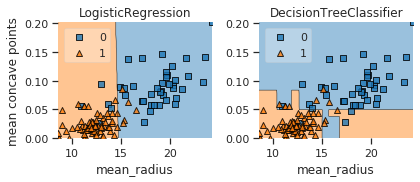

In [94]:
logreg = LogisticRegression(random_state=1)

logreg.fit(X_train, y_train)
clfs = [logreg, dt]

plot_labeled_decision_regions(X_test, y_test, clfs)


In [0]:
accuracy_gini = accuracy_score(y_test, y_pred)

## Decision Trees from Scratch

In [0]:
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]
header = ['color', 'diameter', 'label']
df = pd.DataFrame(training_data, columns=header)

In [0]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [98]:
#######
# Demo:
class_counts(training_data)
#######

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

In [99]:
print(df['color'].unique())
print(df.iloc[:, 0].unique())

['Green' 'Yellow' 'Red']
['Green' 'Yellow' 'Red']


In [100]:
df['label'].value_counts()

Grape    2
Apple    2
Lemon    1
Name: label, dtype: int64

In [0]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [102]:
#######
# Demo:
is_numeric(7)
# is_numeric("Red")
#######

True

In [0]:
class Question:
  def __init__(self, column, value):
    self.column = column
    self.value = value
  
  def match(self, example):
    val = example[self.column]
    if is_numeric(val):
      return val >= self.value
    else:
      return val == self.value

  def __repr__(self):
    condition = '=='
    if is_numeric(self.value):
      condition = '>='
    return f'Is {header[self.column]} {condition} {str(self.value)}?'

In [104]:
Question(1, 3)

Is diameter >= 3?

In [105]:
q = Question(0, 'Green')
q

Is color == Green?

In [106]:
example = training_data[0]
q.match(example)

True

In [107]:
question_color_red = Question(0, 'Red')
print(question_color_red)
question_color_red.match(['Red', 1, 'Grape'])

Is color == Red?


True

In [0]:
def partition(rows, question):
  true_rows, false_rows = [], []
  for row in rows:
    if question.match(row):
      true_rows.append(row)
    else:
      false_rows.append(row)
  return true_rows, false_rows

In [109]:
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
true_rows, false_rows

([['Red', 1, 'Grape'], ['Red', 1, 'Grape']],
 [['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']])

In [0]:
def gini(rows):
  counts = class_counts(rows)
  print(f'counts: {counts}')
  impurity = 1
  for lbl in counts:
    prob_of_lbl = counts[lbl] / float(len(rows))
    impurity -= prob_of_lbl**2
    print(f'impurity: {impurity}')
  return impurity


In [111]:
no_mixing = [['Apple'], ['Apple']]
gini(no_mixing)

counts: {'Apple': 2}
impurity: 0.0


0.0

In [112]:
some_mixing = [['Apple'], ['Orange']]
gini(some_mixing)

counts: {'Apple': 1, 'Orange': 1}
impurity: 0.75
impurity: 0.5


0.5

In [113]:
lots_of_mixing = [['Apple'], ['Orange'], ['Grape'], ['Grapefruit'], ['Blueberry']]
gini(lots_of_mixing)

counts: {'Apple': 1, 'Orange': 1, 'Grape': 1, 'Grapefruit': 1, 'Blueberry': 1}
impurity: 0.96
impurity: 0.9199999999999999
impurity: 0.8799999999999999
impurity: 0.8399999999999999
impurity: 0.7999999999999998


0.7999999999999998

In [114]:
huge_mixing = [['Apple'], ['Apple'], ['Apple'], ['Grape'], ['Grape'], 
                       ['Blueberry'], ['Blueberry'], ['Apple'], ['Apple']]
gini(huge_mixing)

counts: {'Apple': 5, 'Grape': 2, 'Blueberry': 2}
impurity: 0.691358024691358
impurity: 0.6419753086419753
impurity: 0.5925925925925926


0.5925925925925926

In [0]:
def info_gain(left, right, current_uncertainty):
  p = float(len(left)) / (len(left) + len(right))
  return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [116]:
current_uncertainty = gini(training_data)
current_uncertainty

counts: {'Apple': 2, 'Grape': 2, 'Lemon': 1}
impurity: 0.84
impurity: 0.6799999999999999
impurity: 0.6399999999999999


0.6399999999999999

In [117]:
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

counts: {'Apple': 1}
impurity: 0.0
counts: {'Apple': 1, 'Grape': 2, 'Lemon': 1}
impurity: 0.9375
impurity: 0.6875
impurity: 0.625


0.1399999999999999

In [118]:
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

counts: {'Grape': 2}
impurity: 0.0
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445


0.37333333333333324

In [119]:
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [120]:
false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [121]:
# On the other hand, partitioning by Green doesn't help so much.
true_rows, false_rows = partition(training_data, Question(0,'Green'))

# We've isolated one apple in the true rows.
true_rows

[['Green', 3, 'Apple']]

In [122]:
# But, the false-rows are badly mixed up.
false_rows
#######

[['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [0]:
def find_best_split(rows):
  """Find the best question to ask by iterating over every feature / value
  and calculating the information gain."""
  best_gain = 0
  best_question = None
  current_uncertainty = gini(rows)
  n_features = len(rows[0]) - 1
  for col in range(n_features):
    values = set([row[col] for row in rows])
    for val in values:
      question = Question(col, val)
      true_rows, false_rows = partition(rows, question)
      # skip this split if it doesn't divide the dataset
      if len(true_rows) == 0 or len(false_rows) == 0:
        continue
      gain = info_gain(true_rows, false_rows, current_uncertainty)
      if gain >= best_gain:
        best_gain, best_question = gain, question
      
  return best_gain, best_question

In [124]:
#######
# Demo:
# Find the best question to ask first for our toy dataset.
best_gain, best_question = find_best_split(training_data)
best_question
# FYI: is color == Red is just as good. See the note in the code above
# where I used '>='.
#######

counts: {'Apple': 2, 'Grape': 2, 'Lemon': 1}
impurity: 0.84
impurity: 0.6799999999999999
impurity: 0.6399999999999999
counts: {'Apple': 1}
impurity: 0.0
counts: {'Apple': 1, 'Grape': 2, 'Lemon': 1}
impurity: 0.9375
impurity: 0.6875
impurity: 0.625
counts: {'Grape': 2}
impurity: 0.0
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445
counts: {'Apple': 1, 'Lemon': 1}
impurity: 0.75
impurity: 0.5
counts: {'Apple': 1, 'Grape': 2}
impurity: 0.8888888888888888
impurity: 0.4444444444444444
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445
counts: {'Grape': 2}
impurity: 0.0


Is diameter >= 3?

In [0]:
class Leaf:
  """A Leaf node classifies data.

  This holds a dictionary of class (e.g., "Apple") -> number of times
  it appears in the rows from the training data that reach this leaf.
  """
  def __init__(self, rows):
    self.predictions = class_counts(rows)

In [0]:
class DecisionNode:
  """A Decision Node asks a question.
  This holds a reference to the question, and to the two child nodes.
  """
  def __init__(self,
               question,
               true_branch,
               false_branch):
    self.question = question
    self.true_branch = true_branch
    self.false_branch = false_branch

In [0]:
def build_tree(rows):
  """Builds the tree.

  Rules of recursion: 1) Believe that it works. 2) Start by checking
  for the base case (no further information gain). 3) Prepare for
  giant stack traces.
  """
  gain, question = find_best_split(rows)
  if gain == 0:
    return Leaf(rows)

  true_rows, false_rows = partition(rows, question)
  true_branch = build_tree(true_rows)
  false_branch = build_tree(false_rows)
  return DecisionNode(question, true_branch, false_branch)

In [0]:
def print_tree(node, spacing=""):
  """World's most elegant tree printing function."""

  # Base case: we've reached a leaf
  if isinstance(node, Leaf):
      print (spacing + "Predict", node.predictions)
      return

  # Print the question at this node
  print (spacing + str(node.question))

  # Call this function recursively on the true branch
  print (spacing + '--> True:')
  print_tree(node.true_branch, spacing + "  ")

  # Call this function recursively on the false branch
  print (spacing + '--> False:')
  print_tree(node.false_branch, spacing + "  ")

In [129]:
my_tree = build_tree(training_data)

counts: {'Apple': 2, 'Grape': 2, 'Lemon': 1}
impurity: 0.84
impurity: 0.6799999999999999
impurity: 0.6399999999999999
counts: {'Apple': 1}
impurity: 0.0
counts: {'Apple': 1, 'Grape': 2, 'Lemon': 1}
impurity: 0.9375
impurity: 0.6875
impurity: 0.625
counts: {'Grape': 2}
impurity: 0.0
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445
counts: {'Apple': 1, 'Lemon': 1}
impurity: 0.75
impurity: 0.5
counts: {'Apple': 1, 'Grape': 2}
impurity: 0.8888888888888888
impurity: 0.4444444444444444
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445
counts: {'Grape': 2}
impurity: 0.0
counts: {'Apple': 2, 'Lemon': 1}
impurity: 0.5555555555555556
impurity: 0.4444444444444445
counts: {'Apple': 1}
impurity: 0.0
counts: {'Apple': 1, 'Lemon': 1}
impurity: 0.75
impurity: 0.5
counts: {'Apple': 1, 'Lemon': 1}
impurity: 0.75
impurity: 0.5
counts: {'Apple': 1}
impurity: 0.0
counts: {'Apple': 1, 'Lemon': 1}
impurity: 0.75
impurity: 0.5


In [130]:
print_tree(my_tree)

Is diameter >= 3?
--> True:
  Is color == Yellow?
  --> True:
    Predict {'Apple': 1, 'Lemon': 1}
  --> False:
    Predict {'Apple': 1}
--> False:
  Predict {'Grape': 2}


In [0]:
def classify(row, node):
  if isinstance(node, Leaf):
    return node.predictions

  if node.question.match(row):
    return classify(row, node.true_branch)
  else:
    return classify(row, node.false_branch)

In [132]:
#######
# Demo:
# The tree predicts the 1st row of our
# training data is an apple with confidence 1.
classify(training_data[0], my_tree)
#######

{'Apple': 1}

In [0]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [134]:
#######
# Demo:
# Printing that a bit nicer
print_leaf(classify(training_data[0], my_tree))
#######

{'Apple': '100%'}

In [135]:
#######
# Demo:
# On the second example, the confidence is lower
print_leaf(classify(training_data[1], my_tree))
#######

{'Apple': '50%', 'Lemon': '50%'}

In [0]:
# Evaluate
testing_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 4, 'Apple'],
    ['Red', 2, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [137]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: Apple. Predicted: {'Apple': '100%'}
Actual: Apple. Predicted: {'Apple': '50%', 'Lemon': '50%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Lemon. Predicted: {'Apple': '50%', 'Lemon': '50%'}


## Using entropy as a criterion

In [0]:
check_random_state(1)
ds = load_breast_cancer()
X = pd.DataFrame(ds.data[:, [0,7]], columns=['mean_radius', 
                                             'mean concave points'])
y = pd.Series(ds.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [139]:
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=1)
dt_entropy.fit(X_train, y_train)
y_pred = dt_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred)
print('Accuracy achieved by using entropy: ', accuracy_entropy)
print('Accuracy achieved by using the gini index: ', accuracy_gini)

Accuracy achieved by using entropy:  0.9122807017543859
Accuracy achieved by using the gini index:  0.8947368421052632


## Decision Tree for Regression

In [140]:
auto_mpg_url = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/auto_mpg.csv'
mpg = pd.read_csv(auto_mpg_url)
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [141]:
X = mpg.drop(['mpg', 'horsepower', 'car_name'], axis=1)
y = mpg['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=43)
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.13, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=3, splitter='best')

In [142]:
y_pred = dt.predict(X_test)
mse_dt = MSE(y_test, y_pred)
rmse_dt = mse_dt ** 0.5
print(f'Test set RMSE of dt: {rmse_dt:.2f}')

Test set RMSE of dt: 3.93


## The Bias-Variance Tradeoff

In [0]:
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=SEED)
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, 
                            random_state=SEED)

In [144]:
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1)
RMSE_CV = (MSE_CV_scores.mean()) ** (1/2)
f'CV RMSE: {RMSE_CV:.2f}'

'CV RMSE: 4.80'

In [145]:
dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
RMSE_train = (MSE(y_train, y_pred_train)) ** (1/2)
f'Train RMSE: {RMSE_CV:.2f}'


'Train RMSE: 4.80'

## Ensemble Learning

In [0]:
ds = load_breast_cancer()
X = pd.DataFrame(ds.data[:, [0,7]], columns=['mean_radius', 
                                             'mean_concave_points'])
y = pd.Series(ds.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [147]:
SEED = 1
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=27)
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

classifiers = [
  ('Logistic Regression', lr),
  ('K Nearest Neighbours', knn),
  ('Classification Tree', dt)
]

for clf_name, clf in classifiers:
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'{clf_name} : {accuracy:.3f}') 

Logistic Regression : 0.912
K Nearest Neighbours : 0.904
Classification Tree : 0.912


In [148]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Voting Classifier: {accuracy:.3f}')

Voting Classifier: 0.912



## Bagging and Random Forests


In [149]:
dt = DecisionTreeClassifier(random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Test set accuracy of bc: {acc_test:.2f}')

Test set accuracy of bc: 0.93


## Out-of-bag Evaluation

The `Random Forest` classifier is trained using bootstap aggregation, where each tree is fit from a bootstrap sample of the training observations $z_i=(x_i, y_i)$. The *out-of-bag* (OOB) error is the average error for each $z_i$ calculated using predictions from the trees that do not contain $z_i$ in their bootstrap sample. This allows `Random Forest` to be fit and validated whilst being trained.

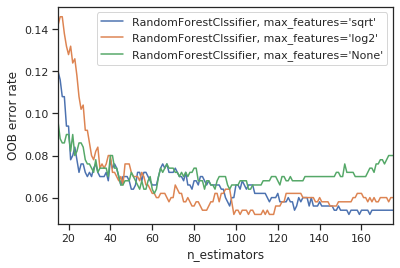

In [150]:
rs = check_random_state(123)
X, y = make_classification(n_samples=500, n_features=25, n_clusters_per_class=1,
                           n_informative=15, random_state=rs)
ensemble_clfs = [
  ("RandomForestClssifier, max_features='sqrt'",
   RandomForestClassifier(warm_start=True, oob_score=True, max_features='sqrt',
                          random_state=rs)),
  ("RandomForestClssifier, max_features='log2'",
   RandomForestClassifier(warm_start=True, oob_score=True, max_features='log2',
                          random_state=rs)),
  ("RandomForestClssifier, max_features='None'",
   RandomForestClassifier(warm_start=True, oob_score=True, max_features=None,
                          random_state=rs))    
]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
  for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(X, y)
    oob_error = 1 - clf.oob_score_
    error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
  xs, ys = zip(*clf_err)
  plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel('n_estimators')
plt.ylabel('OOB error rate')
plt.legend(loc='upper right');

## OOB score vs Test set score

In [151]:
rs = check_random_state(1)
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=rs)
bc = BaggingClassifier(
    base_estimator=dt,
    n_estimators=50,
    oob_score=True,
    random_state=1
)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
acc_oob = bc.oob_score_
print(f'Test set accuracy: {acc_test:.3f}, OOB accuracy: {acc_oob:.3f}')

Test set accuracy: 0.930, OOB accuracy: 0.910


## Train an RF regressor

In [152]:
rs = check_random_state(43)
bike = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/bike_sharing_demand_train.csv'

train_df = pd.read_csv(bike, parse_dates=['datetime'])
train_df['yr'] = train_df['datetime'].apply(lambda x: x.year)
train_df['mnth'] = train_df['datetime'].apply(lambda x: x.month)
train_df['hr'] = train_df['datetime'].apply(lambda x: x.hour)
train_df['weekday'] = train_df['datetime'].apply(lambda x: x.weekday())

le = LabelEncoder()
train_df['yr'] = le.fit_transform(train_df['yr'])
train_df['mnth'] = le.fit_transform(train_df['mnth'])

train_df = train_df.drop(['datetime', 'registered', 'casual'], axis=1)

train_df.shape

(10886, 13)

In [0]:
X, y = train_df.drop(['count'], axis=1), train_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=rs)

In [154]:
rf = RandomForestRegressor(n_estimators=25, random_state=rs)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=RandomState(MT19937) at 0x7FBB44675360,
                      verbose=0, warm_start=False)

In [155]:
# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred) ** (1/2)

print(f'Test set RMSE of rf: {rmse_test:.2f}')

Test set RMSE of rf: 42.24


## Visualizing features importances

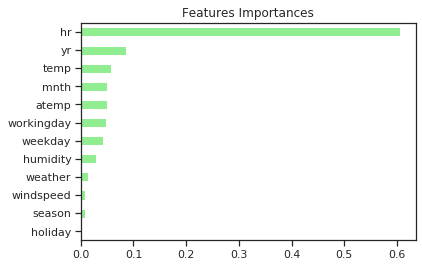

In [156]:
importances = pd.Series(data=rf.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances');

## AdaBoost

In [0]:
rs = check_random_state(1)
liver = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/indian_liver_patient.csv'
df = pd.read_csv(liver)
df['is_female'] = df['gender'].replace({'Female' : 0, 'Male' : 1})
le = LabelEncoder()
df['age'] = le.fit_transform(df['age'])
X = df.drop(['is_patient', 'alkphos', 'gender'], axis=1)
y = df['is_patient']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=rs)

In [0]:
dt = DecisionTreeClassifier(max_depth=2, random_state=rs)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=rs)
ada.fit(X_train, y_train)
y_pred_proba = ada.predict_proba(X_test)[:, 1]

In [159]:
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.64


## Gradient Boosting

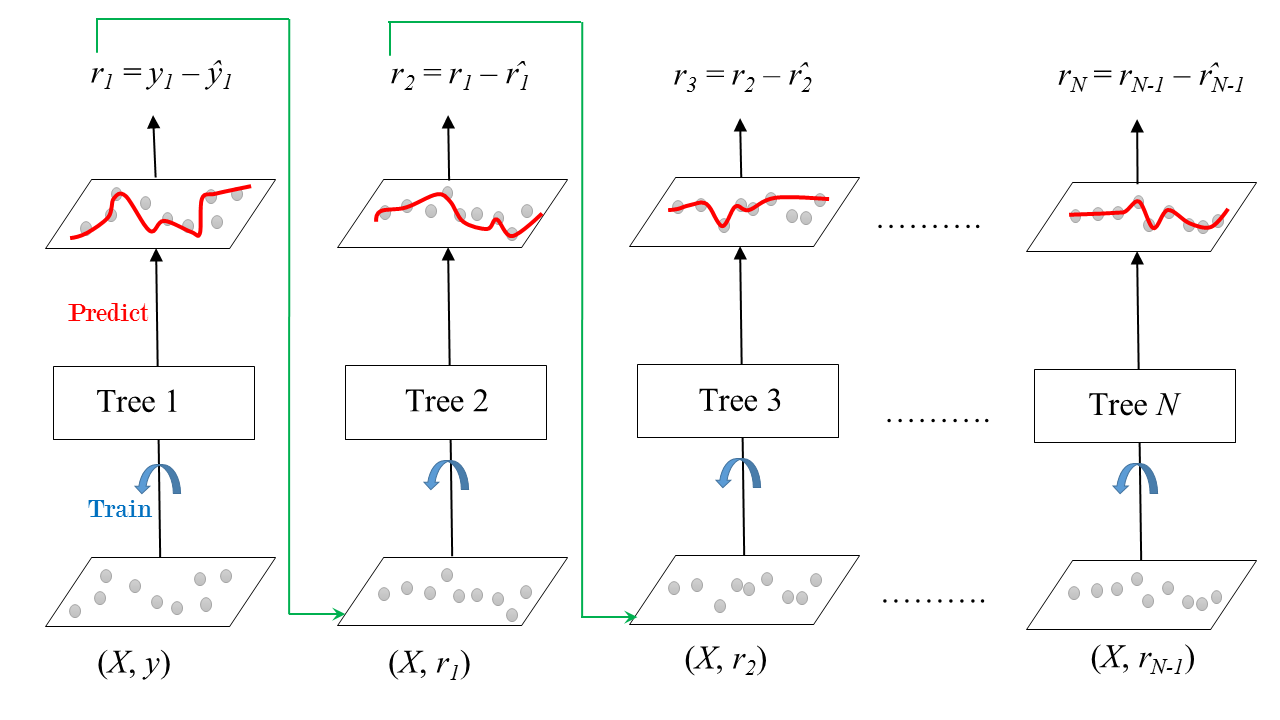

In [160]:
Image(filename='colab-notebooks/ensemble-learning/images/gradient-boosting-01.png', width=500)

In [161]:
rs = check_random_state(2)
bike = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/bike_sharing_demand_train.csv'

train_df = pd.read_csv(bike, parse_dates=['datetime'])
train_df['yr'] = train_df['datetime'].apply(lambda x: x.year)
train_df['mnth'] = train_df['datetime'].apply(lambda x: x.month)
train_df['hr'] = train_df['datetime'].apply(lambda x: x.hour)
train_df['weekday'] = train_df['datetime'].apply(lambda x: x.weekday())

le = LabelEncoder()
train_df['yr'] = le.fit_transform(train_df['yr'])
train_df['mnth'] = le.fit_transform(train_df['mnth'])

train_df = train_df.drop(['datetime', 'registered', 'casual'], axis=1)

train_df.shape

(10886, 13)

In [162]:
gb = GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=rs)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.481


## Stochastic Gradient Boosting

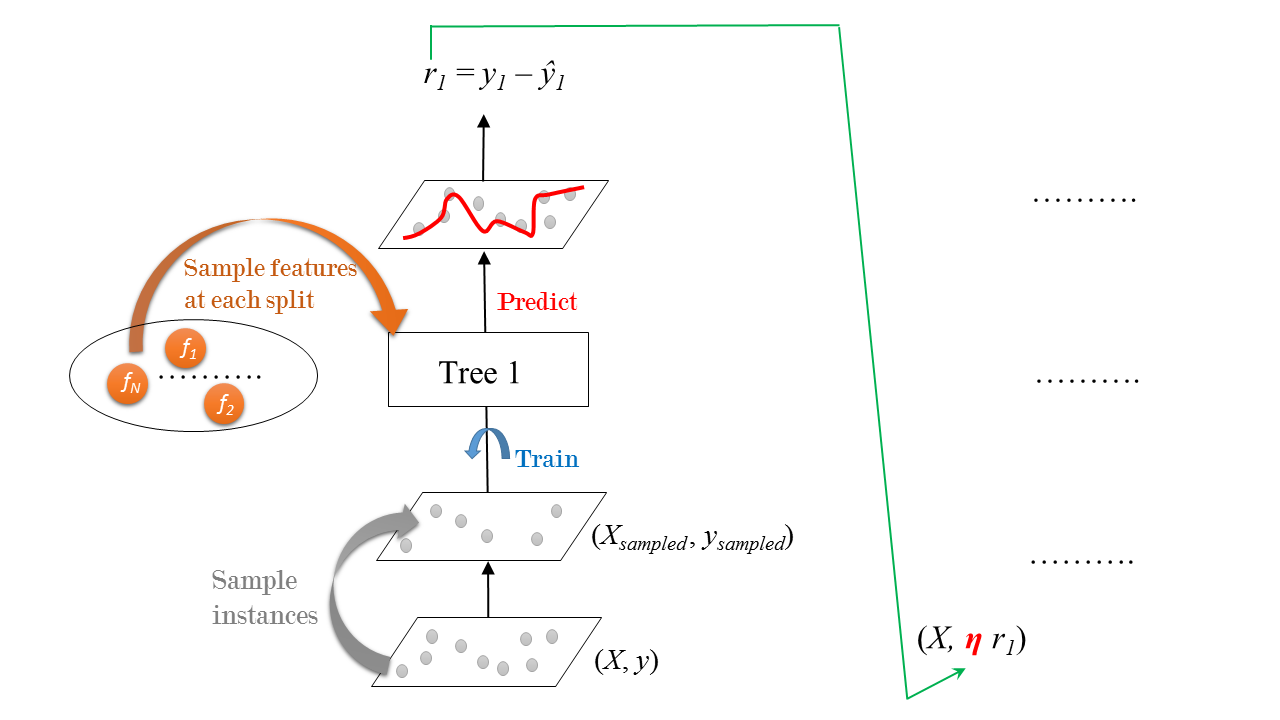

In [163]:
Image(filename='colab-notebooks/ensemble-learning/images/stochastic-gradient-boosting-01.png', width=500)

In [0]:
rs = check_random_state(2)
bike = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/bike_sharing_demand_train.csv'

train_df = pd.read_csv(bike, parse_dates=['datetime'])
train_df['yr'] = train_df['datetime'].apply(lambda x: x.year)
train_df['mnth'] = train_df['datetime'].apply(lambda x: x.month)
train_df['hr'] = train_df['datetime'].apply(lambda x: x.hour)
train_df['weekday'] = train_df['datetime'].apply(lambda x: x.weekday())

le = LabelEncoder()
train_df['yr'] = le.fit_transform(train_df['yr'])
train_df['mnth'] = le.fit_transform(train_df['mnth'])

train_df = train_df.drop(['datetime', 'registered', 'casual'], axis=1)
X, y = train_df.drop(['count'], axis=1), train_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=rs)


In [185]:
sgbr = GradientBoostingRegressor(
    max_depth=4,
    subsample=0.9,
    max_features=0.75,
    n_estimators=200,
    random_state=rs
)
sgbr.fit(X_train, y_train)
y_pred = sgbr.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 46.921


## Model Tuning

In [0]:
rs = check_random_state(1)
liver = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/indian_liver_patient.csv'
df = pd.read_csv(liver)
df['is_female'] = df['gender'].replace({'Female' : 0, 'Male' : 1})
le = LabelEncoder()
df['age'] = le.fit_transform(df['age'])
X = df.drop(['is_patient', 'alkphos', 'gender'], axis=1)
y = df['is_patient']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=rs)

In [187]:
params_dt = {
    'max_depth' : [2, 3, 4], 
    'min_samples_leaf' : [0.12, 0.14, 0.16, 0.18]
}
dt = DecisionTreeClassifier(random_state=rs)
grid_dt = GridSearchCV(
    estimator = dt,
    param_grid = params_dt,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)
best_model = grid_dt.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Test set ROC AUC score: {test_roc_auc:.3f}')

Test set ROC AUC score: 0.685


In [188]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=RandomState(MT19937) at 0x7FBB445CB048,
                       splitter='best')

## Tune Random Forest Hyperparameters

In [0]:
rs = check_random_state(2)
bike = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/bike_sharing_demand_train.csv'

train_df = pd.read_csv(bike, parse_dates=['datetime'])
train_df['yr'] = train_df['datetime'].apply(lambda x: x.year)
train_df['mnth'] = train_df['datetime'].apply(lambda x: x.month)
train_df['hr'] = train_df['datetime'].apply(lambda x: x.hour)
train_df['weekday'] = train_df['datetime'].apply(lambda x: x.weekday())

le = LabelEncoder()
train_df['yr'] = le.fit_transform(train_df['yr'])
train_df['mnth'] = le.fit_transform(train_df['mnth'])

train_df = train_df.drop(['datetime', 'registered', 'casual'], axis=1)

X, y = train_df.drop(['count'], axis=1), train_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=rs)

In [198]:
rf = RandomForestRegressor(random_state=rs)
params_rf = {
    'n_estimators' : [100, 350, 500],
    'max_features' : ['log2', 'auto', 'sqrt'],
    'min_samples_leaf' : [2, 10, 30]
}
grid_rf = GridSearchCV(
    estimator = rf,
    param_grid = params_rf,
    scoring = 'neg_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1
)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=RandomState(MT19937) at 0x7FBB4763FBA0,
                               

In [199]:
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print(f'Test RMSE of best model: {rmse_test:.3f}') 

Test RMSE of best model: 44.029
